In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import required libraries
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as pc

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
# unzip the data
!unzip '/content/drive/MyDrive/colabdataset/train_naive_approch.zip'

Archive:  /content/drive/MyDrive/colabdataset/train_naive_approch.zip
   creating: train_naive_approch/
   creating: train_naive_approch/images/
  inflating: train_naive_approch/images/2007_000027.jpg  
  inflating: train_naive_approch/images/2007_000032.jpg  
  inflating: train_naive_approch/images/2007_000033.jpg  
  inflating: train_naive_approch/images/2007_000039.jpg  
  inflating: train_naive_approch/images/2007_000042.jpg  
  inflating: train_naive_approch/images/2007_000061.jpg  
  inflating: train_naive_approch/images/2007_000063.jpg  
  inflating: train_naive_approch/images/2007_000068.jpg  
  inflating: train_naive_approch/images/2007_000121.jpg  
  inflating: train_naive_approch/images/2007_000123.jpg  
  inflating: train_naive_approch/images/2007_000129.jpg  
  inflating: train_naive_approch/images/2007_000170.jpg  
  inflating: train_naive_approch/images/2007_000175.jpg  
  inflating: train_naive_approch/images/2007_000187.jpg  
  inflating: train_naive_approch/images/200

In [ ]:
# reading csv file
data = pd.read_csv('/content/drive/MyDrive/colabdataset/train.csv')
data.head(20)

,filename,class,xmin,xmax,ymin,ymax
0,2007_000027.jpg,person,174,349,101,351
1,2007_000032.jpg,aeroplane,104,375,78,183
2,2007_000032.jpg,aeroplane,133,197,88,123
3,2007_000032.jpg,person,195,213,180,229
4,2007_000032.jpg,person,26,44,189,238
5,2007_000033.jpg,aeroplane,9,499,107,263
6,2007_000033.jpg,aeroplane,421,482,200,226
7,2007_000033.jpg,aeroplane,325,411,188,223
8,2007_000039.jpg,tvmonitor,156,344,89,279
9,2007_000042.jpg,train,263,500,32,295


In [ ]:
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
data['class']= label_encoder.fit_transform(data['class'])

In [ ]:
# defining required transformations
from torchvision import transforms as TF #brings in the transforms module from the torchvision library,

transform = TF.Compose([                                 #composes several transforms together.
    TF.Resize((224, 224)),
    TF.ToTensor()                                        #converts a PIL image or a NumPy ndarray into a PyTorch tensor.
])

In [ ]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# defining class to load data
class BloodCellDataset(torch.utils.data.Dataset):  # Defines a new class BloodCellDataset that inherits from PyTorch's Dataset
    def __init__(self, root, transforms=None):     # Initializer or constructor for the BloodCellDataset class ,root is the path to the directory where the images are stored.
        self.root = root                           # we store the root directory path in the instance variable self.root
        self.transforms = transforms
        # load all image files
        self.imgs = data.filename.unique()     #image_names column contains the names of image files,It extracts the unique image names and stores them in the instance variable self.imgs.

    def __getitem__(self, idx): #This method is required by the PyTorch Dataset interface. It retrieves the idx-th sample from the dataset
        # load images
        img_name = self.imgs[idx] #This line gets the image filename at the given index idx.
        img_path = os.path.join(self.root, img_name)#It constructs the full path to the image by joining the root directory and the image filename.
        img = Image.open(img_path)#his line uses the PIL library to open the image file

        num_objs = data[data['filename'] == img_name].shape[0] #This counts the number of objects (cells) in the current image by filtering the data DataFrame
        boxes = []
        cell_type = []
        for i in range(num_objs):
            xmin = data[data['filename'] == img_name]['xmin'].iloc[i] # xmin
            xmax = data[data['filename'] == img_name]['xmax'].iloc[i] # xmax
            ymin = data[data['filename'] == img_name]['ymin'].iloc[i] # ymin
            ymax = data[data['filename'] == img_name]['ymax'].iloc[i] # ymax
            target = data[data['filename'] == img_name]['class'].iloc[i] # Target-WBC or RBC
            boxes.append([xmin, ymin, xmax, ymax])
            cell_type.append(target)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(cell_type, dtype=torch.int64)

        target = {} #These lines create a dictionary to store the tensors for bounding boxes and labels
        target["boxes"] = boxes
        target["labels"] = labels
        if self.transforms is not None:
            img = self.transforms(img)
            boxes[:, 0] = boxes[:, 0] * (224/640) # we have to resize the boxes as we are resizing image
            boxes[:, 2] = boxes[:, 2] * (224/640)
            boxes[:, 1] = boxes[:, 1] * (224/480)
            boxes[:, 3] = boxes[:, 3] * (224/480)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# defining data loader
data_loader = torch.utils.data.DataLoader(     #initializes a new DataLoader object from the PyTorch torch.utils.data
    dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [ ]:
# define model
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 104MB/s]


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_classes = 3   # one class for background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))

In [ ]:
# transfer model to GPU
model = model.to("cuda")

In [ ]:
# define optimization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision



In [1]:
from zipfile import ZipFile
import os

# Define the path for the uploaded ZIP file and the target extraction directory
zip_file_path = '/content/drive/MyDrive/dataset_pascalVOCDetection-200625-193221.zip'
extraction_dir = 'dataset/'

# Extract the ZIP file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List the contents of the extraction directory to verify the structure
extracted_contents = os.listdir(extraction_dir)
extracted_contents


['train.csv', 'val_images', 'val.csv', 'train_images']

In [2]:
import pandas as pd

# Load the CSV files into Pandas DataFrames
train_csv_path = os.path.join(extraction_dir, 'train.csv')
val_csv_path = os.path.join(extraction_dir, 'val.csv')
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Display the first few rows of each DataFrame to inspect their structure
train_df_head = train_df.head()
val_df_head = val_df.head()

(train_df_head, val_df_head)


(          filename      class  xmin  xmax  ymin  ymax
 0  2007_000027.jpg     person   174   349   101   351
 1  2007_000032.jpg  aeroplane   104   375    78   183
 2  2007_000032.jpg  aeroplane   133   197    88   123
 3  2007_000032.jpg     person   195   213   180   229
 4  2007_000032.jpg     person    26    44   189   238,
           filename   class  xmin  xmax  ymin  ymax
 0  2008_001513.jpg     cat    99   454   104   287
 1  2008_001514.jpg    bird   129   391    66   262
 2  2008_001516.jpg  person   250   293   281   314
 3  2008_001516.jpg  person   182   195   292   312
 4  2008_001516.jpg  person   166   183   292   313)

In [4]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

In [ ]:
# Update paths accordingly
train_csv_path = '/content/dataset/train.csv'
val_csv_path = '/content/dataset/val.csv'
train_img_dir = '/content/dataset/train_images'
val_img_dir = '/content/dataset/val_images'

# Update class names according to your dataset
classes = ['background', 'person', 'aeroplane', 'tvmonitor', 'train', 'boat', 'dog', 'chair', 'bird', 'bicycle', 'bottle', 'sheep', 'diningtable', 'horse', 'motorbike', 'sofa', 'cow', 'car', 'cat', 'bus', 'pottedplant']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

In [5]:
# Randomly select 200 unique images for training
selected_images = train_df['filename'].drop_duplicates().sample(n=200, random_state=1)

# Filter the training DataFrame to include only the selected images
filtered_train_df = train_df[train_df['filename'].isin(selected_images)]

# Check the size of the filtered training DataFrame and display the first few rows
filtered_train_df.shape, filtered_train_df


((516, 6),
              filename      class  xmin  xmax  ymin  ymax
 8     2007_000039.jpg  tvmonitor   156   344    89   279
 41    2007_000323.jpg     person   277   500     3   375
 42    2007_000323.jpg     person    12   305     3   375
 66    2007_000491.jpg        cow     2   459     2   334
 81    2007_000572.jpg    bicycle     1   235   178   331
 ...               ...        ...   ...   ...   ...   ...
 3875  2008_001437.jpg     person     1   135   183   375
 3876  2008_001437.jpg     person   126   186   185   375
 3877  2008_001437.jpg     person   247   343   187   375
 3915  2008_001454.jpg     person     5   490     1   500
 3925  2008_001462.jpg     person    80   208    67   293
 
 [516 rows x 6 columns])

In [6]:
# Save the filtered training DataFrame to a new CSV file
filtered_train_csv_path = '/content/dataset/filtered_train.csv'
filtered_train_df.to_csv(filtered_train_csv_path, index=False)


In [8]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_to_idx, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_to_idx = class_to_idx
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.ToTensor()  # Ensure all images are converted to Tensor.
        ])

    def __len__(self):
        return len(self.data_frame['filename'].unique())

    def __getitem__(self, idx):
        img_name = self.data_frame['filename'].unique()[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        img_df = self.data_frame[self.data_frame['filename'] == img_name]
        boxes = img_df[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = img_df['class'].apply(lambda x: self.class_to_idx[x]).values

        image = self.transform(image)

        target = {}
        target['boxes'] = torch.tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)

        return image, target


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a pre-trained model for classification and return only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

# Define the anchor generator for the RPN
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

# Define the RoI pooling
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone, num_classes=len(classes), rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s] 


In [10]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_to_idx, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            class_to_idx (dict): A dictionary mapping class names to indices.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.data_frame['filename'].unique())

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        # Note: Adjusting to handle multiple objects in the image
        img_records = self.data_frame[self.data_frame['filename'] == self.data_frame.iloc[idx, 0]]
        boxes = img_records[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = img_records['class'].apply(lambda x: self.class_to_idx[x]).values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            image = self.transform(image)

        return image, target


In [11]:
from torchvision import transforms

# Assuming the classes list and class_to_idx mapping is already defined
classes = ['background', 'person', 'aeroplane', 'tvmonitor', 'train', 'boat',
           'dog', 'chair', 'bird', 'bicycle', 'bottle', 'sheep', 'diningtable',
           'horse', 'motorbike', 'sofa', 'cow', 'car', 'cat', 'bus', 'pottedplant']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Define the path to your filtered training CSV and image directories
filtered_train_csv_path = '/content/dataset/filtered_train.csv'  # Adjust this path if necessary
train_img_dir = '/content/dataset/train_images'
val_csv_path = '/content/dataset/val.csv'
val_img_dir = '/content/dataset/val_images'

# Define transformation
transform = transforms.Compose([transforms.ToTensor()])

# Initialize CustomDataset instances
train_dataset = CustomDataset(csv_file=filtered_train_csv_path, img_dir=train_img_dir, class_to_idx=class_to_idx, transform=transform)
val_dataset = CustomDataset(csv_file=val_csv_path, img_dir=val_img_dir, class_to_idx=class_to_idx, transform=transform)


In [13]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
num_classes = len(classes)  # Including the background
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model = model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 74.9MB/s]


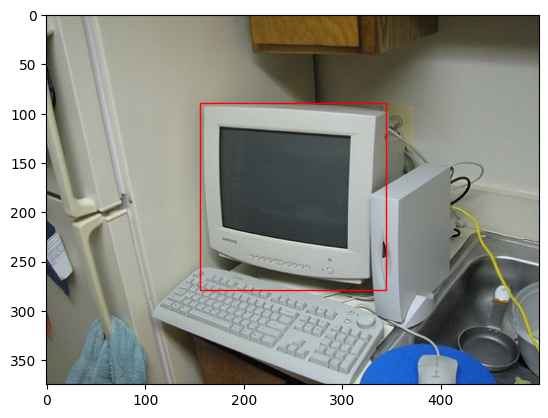

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import make_grid
import numpy as np

def show_image_with_boxes(dataset, idx):
    # Get the image and the target info
    img, target = dataset[idx]
    img = img.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    npimg = img.numpy()

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(npimg)

    # Create a Rectangle patch for each bounding box and add it to the plot
    for box in target['boxes']:
        x, y, xmax, ymax = box
        rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Display an image from the training dataset
show_image_with_boxes(train_dataset, 0)


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

# DataLoader setup
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} of {num_epochs} completed.")
